In [1]:
import pandas as pd
from torch.utils.data import Dataset
import torch
import os
import random
import numpy as np
from torch import nn
from typing import Dict, Optional, Tuple, List
from transformers import AutoTokenizer, AutoModel
from torch.utils.data import Dataset, random_split
import torch.optim as optim
from tqdm import tqdm
from sklearn.metrics import precision_score, f1_score, recall_score, classification_report

In [2]:
SEED = 42

torch.manual_seed(SEED)
torch.random.manual_seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.cuda.random.manual_seed(SEED)
torch.cuda.random.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
!git clone https://github.com/uhh-lt/TextGraphs17-shared-task.git

Cloning into 'TextGraphs17-shared-task'...
remote: Enumerating objects: 498, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 498 (delta 7), reused 14 (delta 4), pack-reused 480
Receiving objects: 100% (498/498), 37.10 MiB | 39.08 MiB/s, done.
Resolving deltas: 100% (58/58), done.


In [5]:
!ls TextGraphs17-shared-task

README.md  data        question_graph_examples	visualization
baselines  evaluation  reformat_data


In [6]:
train_dev_path = "TextGraphs17-shared-task/data/tsv/train.tsv"

data_df = pd.read_csv(train_dev_path, sep='\t')

In [7]:
all_questions = list(data_df["question"].unique())
num_questions = len(all_questions)
random.shuffle(all_questions)

In [8]:
train_dev_ratio = 0.8
train_ratio = 0.9
num_train_dev_questions = int(num_questions * train_dev_ratio)
train_dev_questions = all_questions[:num_train_dev_questions]
test_questions = set(all_questions[num_train_dev_questions:])
num_train_questions = int(len(train_dev_questions) * train_ratio)
train_questions = set(train_dev_questions[:num_train_questions])
dev_questions = set(train_dev_questions[num_train_questions:])

print(f"Questions: train - {len(train_questions)}, dev - {len(dev_questions)}, test - {len(dev_questions)}")

Questions: train - 2545, dev - 283, test - 283


In [9]:
train_df = data_df[data_df["question"].isin(train_questions)]
dev_df = data_df[data_df["question"].isin(dev_questions)]
test_df = data_df[data_df["question"].isin(test_questions)]

print(f"Train: {train_df.shape}")
print(f"Dev: {dev_df.shape}")
print(f"Test: {test_df.shape}")

Train: (27122, 10)
Dev: (3047, 10)
Test: (7503, 10)


In [10]:
train_df.loc[0, "graph"]

'{\'nodes\': [{\'type\': \'QUESTIONS_ENTITY\', \'name_\': \'Q794\', \'id\': 0, \'label\': \'Iran\'}, {\'type\': \'INTERNAL\', \'name_\': \'Q207991\', \'id\': 1, \'label\': \'Pahlavi dynasty\'}, {\'type\': \'ANSWER_CANDIDATE_ENTITY\', \'name_\': \'Q7293530\', \'id\': 2, \'label\': "Ruhollah Khomeini\'s return to Iran"}], \'links\': [{\'name_\': \'P17\', \'source\': 0, \'target\': 0, \'label\': \'country\'}, {\'name_\': \'P1365\', \'source\': 0, \'target\': 1, \'label\': \'replaces\'}, {\'name_\': \'P1366\', \'source\': 1, \'target\': 0, \'label\': \'replaced by\'}, {\'name_\': \'P17\', \'source\': 2, \'target\': 1, \'label\': \'country\'}]}'

In [11]:
train_df.head()

,sample_id,question,questionEntity,answerEntity,groundTruthAnswerEntity,answerEntityId,questionEntityId,groundTruthAnswerEntityId,correct,graph
0,0,Whst is the name of the head of state and high...,Iran,Ruhollah Khomeini's return to Iran,Office of the Supreme Leader of Iran,Q7293530,Q794,Q16045000,False,"{'nodes': [{'type': 'QUESTIONS_ENTITY', 'name_..."
1,1,Whst is the name of the head of state and high...,Iran,Ruhollah Khomeini's letter to Mikhail Gorbachev,Office of the Supreme Leader of Iran,Q5952984,Q794,Q16045000,False,"{'nodes': [{'type': 'INTERNAL', 'name_': 'Q417..."
2,2,Whst is the name of the head of state and high...,Iran,Ruhollah Khomeini,Office of the Supreme Leader of Iran,Q38823,Q794,Q16045000,False,"{'nodes': [{'type': 'QUESTIONS_ENTITY', 'name_..."
3,3,Whst is the name of the head of state and high...,Iran,Office of the Supreme Leader of Iran,Office of the Supreme Leader of Iran,Q16045000,Q794,Q16045000,True,"{'nodes': [{'type': 'QUESTIONS_ENTITY', 'name_..."
4,4,Whst is the name of the head of state and high...,Iran,Mohammad Reza Pahlavi and Soraya,Office of the Supreme Leader of Iran,Q63195813,Q794,Q16045000,False,"{'nodes': [{'type': 'QUESTIONS_ENTITY', 'name_..."


In [12]:
train_df.loc[:,"label"] = train_df["correct"].astype(np.float32)
dev_df.loc[:,"label"] = dev_df["correct"].astype(np.float32)
test_df.loc[:,"label"] = test_df["correct"].astype(np.float32)
train_df["label"].head(5)

/tmp/ipykernel_24/1869300941.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.loc[:,"label"] = train_df["correct"].astype(np.float32)
/tmp/ipykernel_24/1869300941.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dev_df.loc[:,"label"] = dev_df["correct"].astype(np.float32)
/tmp/ipykernel_24/1869300941.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: ht

0    0.0
1    0.0
2    0.0
3    1.0
4    0.0
Name: label, dtype: float32

In [13]:
train_df.loc[:,"graph"] = train_df["graph"].apply(eval)
dev_df.loc[:,"graph"] = dev_df["graph"].apply(eval)
test_df.loc[:,"graph"] = test_df["graph"].apply(eval)

In [14]:
train_df[["question", "answerEntity", "groundTruthAnswerEntity", "label"]].head(10)

,question,answerEntity,groundTruthAnswerEntity,label
0,Whst is the name of the head of state and high...,Ruhollah Khomeini's return to Iran,Office of the Supreme Leader of Iran,0.0
1,Whst is the name of the head of state and high...,Ruhollah Khomeini's letter to Mikhail Gorbachev,Office of the Supreme Leader of Iran,0.0
2,Whst is the name of the head of state and high...,Ruhollah Khomeini,Office of the Supreme Leader of Iran,0.0
3,Whst is the name of the head of state and high...,Office of the Supreme Leader of Iran,Office of the Supreme Leader of Iran,1.0
4,Whst is the name of the head of state and high...,Mohammad Reza Pahlavi and Soraya,Office of the Supreme Leader of Iran,0.0
5,Whst is the name of the head of state and high...,Mahmoud Ahmadinejad,Office of the Supreme Leader of Iran,0.0
6,Whst is the name of the head of state and high...,Hassan Rouhani,Office of the Supreme Leader of Iran,0.0
7,Whst is the name of the head of state and high...,Ayatollah Khamenei's Foreign Policy Orientation,Office of the Supreme Leader of Iran,0.0
8,Whst is the name of the head of state and high...,Ayatollah Ali Khamenei speaks about Iranian pr...,Office of the Supreme Leader of Iran,0.0
9,Whst is the name of the head of state and high...,Ali Khamenei bibliography,Office of the Supreme Leader of Iran,0.0


In [15]:
test_df[["question", "answerEntity", "groundTruthAnswerEntity", "label"]].head(10)

,question,answerEntity,groundTruthAnswerEntity,label
11,Whose is the oldest MLB player to hit a home run?,Yogi Berra,Julio Franco,0.0
12,Whose is the oldest MLB player to hit a home run?,"Tony Gwynn, Jr.",Julio Franco,0.0
13,Whose is the oldest MLB player to hit a home run?,Roy Campanella,Julio Franco,0.0
14,Whose is the oldest MLB player to hit a home run?,Roger Clemens,Julio Franco,0.0
15,Whose is the oldest MLB player to hit a home run?,Mickey Mantle,Julio Franco,0.0
16,Whose is the oldest MLB player to hit a home run?,Lou Gehrig,Julio Franco,0.0
17,Whose is the oldest MLB player to hit a home run?,Julio Franco,Julio Franco,1.0
18,Whose is the oldest MLB player to hit a home run?,José Bautista,Julio Franco,0.0
19,Whose is the oldest MLB player to hit a home run?,Hank Greenberg,Julio Franco,0.0
20,Whose is the oldest MLB player to hit a home run?,Hank Aaron,Julio Franco,0.0


In [16]:
class QuestionAnswerDataset(Dataset):

    def __init__(self, df, tokenizer, max_length, context_key="answerEntity",
                 tokenizer_truncation="only_first"):
        super(QuestionAnswerDataset).__init__()

        self.questions = df.question.values
        self.contexts = df[context_key].values
        self.labels = torch.tensor(df.label.values, dtype=torch.float32)
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.tokenized_input = [tokenizer.encode_plus(x, y,
                              max_length=self.max_length,
                              padding="max_length",
                              truncation=tokenizer_truncation,
                              return_tensors="pt", ) \
                          for x, y in zip(self.questions,
                                          self.contexts)]
        assert len(self.questions) == len(self.contexts) == len(self.labels)

    def __len__(self):
        return len(self.questions)

    def __getitem__(self, idx):
        return {
                "input_ids": self.tokenized_input[idx]["input_ids"][0],
                "attention_mask" : self.tokenized_input[idx]["attention_mask"][0],
                "labels": self.labels[idx]}

In [17]:
# train_ratio=0.9
# train_df = train_dev_df.sample(frac=train_ratio)
# dev_df = train_dev_df.drop(train_df.index)

In [18]:
model_name="sentence-transformers/all-MiniLM-L6-v2"

tokenizer = AutoTokenizer.from_pretrained(model_name)
bert_model = AutoModel.from_pretrained(model_name)

freeze_embeddings = True
if freeze_embeddings:
    for param in bert_model.embeddings.parameters():
        param.requires_grad = False

# freeze_layer_count = 5
# if freeze_layer_count > 0:
#     for layer in bert_model.encoder.layer[:freeze_layer_count]:
#         for param in layer.parameters():
#             param.requires_grad = False

print("# Trainable params: ", sum(p.numel() for p in bert_model.parameters() if p.requires_grad))

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

# Trainable params:  10794624


In [19]:
max_length = 128
train_dataset = QuestionAnswerDataset(train_df, tokenizer=tokenizer, max_length=max_length)
dev_dataset = QuestionAnswerDataset(dev_df, tokenizer=tokenizer, max_length=max_length)
test_dataset = QuestionAnswerDataset(test_df, tokenizer=tokenizer, max_length=max_length)

In [20]:
batch_size = 64
num_workers = 0

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True, drop_last=True,
)
dev_loader = torch.utils.data.DataLoader(
    dev_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False, drop_last=False,
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False, drop_last=False,
)

In [21]:
def train(model, iterator, optimizer, criterion, device,
          train_history=None, valid_history=None,):
    model.train()

    epoch_loss = 0
    history = []
    for i, batch in enumerate(tqdm(iterator)):

        optimizer.zero_grad()

        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)
        output = model(inputs=input_ids, attention_mask=attention_mask,).squeeze(1)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        # scheduler.step()

        epoch_loss += loss.item()

        history.append(loss.cpu().data.numpy())

    return epoch_loss / (i + 1)

def evaluate(model, iterator, criterion, device):
    model.eval()

    epoch_loss = 0

    true_labels = []
    pred_labels = []

    with torch.no_grad():

        for i, batch in enumerate(iterator):

            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"]

            true_labels.extend(labels.cpu().numpy())
            labels = labels.to(device)


            output = model(inputs=input_ids, attention_mask=attention_mask,).squeeze(1)
            pred_probas = output.cpu().numpy()
            batch_pred_labels = (pred_probas >= 0.5) * 1

            loss = criterion(output, labels)

            pred_labels.extend(batch_pred_labels)
            epoch_loss += loss.item()

    valid_f1_score = f1_score(true_labels, pred_labels)
    return epoch_loss / (i + 1), valid_f1_score

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [22]:
import time
import math
import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

In [23]:
def train_evaluate(bert_classifier, train_loader, dev_loader, optimizer, criterion, n_epochs, checkpoint_fname, device):
    train_history = []
    valid_history = []
    valid_history_f1 = []

    best_valid_loss = float('inf')
    best_f1_score = 0.0

    for epoch in range(n_epochs):

        start_time = time.time()

        train_loss = train(bert_classifier, train_loader, optimizer, criterion, device, train_history, valid_history, )
        valid_loss, valid_f1_score = evaluate(bert_classifier, dev_loader, criterion, device)

        end_time = time.time()

        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        train_history.append(train_loss)
        valid_history.append(valid_loss)
        valid_history_f1.append(valid_f1_score)

        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

        clear_output(True)
        ax[0].plot(valid_history_f1, label='Val f1-score')
        ax[0].set_xlabel('Epoch')
        ax[0].set_title('Val f1-score')

        ax[1].plot(train_history, label='general train history')
        ax[1].set_xlabel('Epoch')
        ax[1].plot(valid_history, label='general valid history')

        plt.legend()
        plt.show()

        if valid_f1_score > best_f1_score:
            best_f1_score = valid_f1_score
            torch.save(bert_classifier.state_dict(), f'best-val-{checkpoint_fname}.pt')

        print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f}')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. F1: {valid_f1_score:.3f}')

In [24]:
def predict(model, data_loader, device):
    true_labels = []
    pred_labels = []

    model.eval()
    with torch.no_grad():
        for i, batch in enumerate(data_loader):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            batch_true_labels = batch["labels"].cpu().numpy()


            pred_probas = model(inputs=input_ids, attention_mask=attention_mask,).squeeze(1)
            pred_probas = pred_probas.cpu().numpy()

            batch_pred_labels = (pred_probas >= 0.5) * 1

            pred_labels.extend(batch_pred_labels)
            true_labels.extend(batch_true_labels)
    return true_labels, pred_labels

In [25]:
class BertSimpleClassifier(nn.Module):
    def __init__(self, bert_text_encoder, dropout=0.1):
        super().__init__()

        self.bert_text_encoder = bert_text_encoder
        self.dropout = nn.Dropout(p=dropout)
        bert_hidden_dim = bert_text_encoder.config.hidden_size

        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Tanh(),
            nn.Linear(bert_hidden_dim, bert_hidden_dim),
            nn.Dropout(p=dropout),
            nn.Tanh(),
            nn.Linear(bert_hidden_dim, 1),
        )


    def forward(self, inputs, attention_mask,):
        last_hidden_states = self.bert_text_encoder(inputs, attention_mask=attention_mask,
                                                    return_dict=True)['last_hidden_state']
        text_cls_embeddings = torch.stack([elem[0, :] for elem in last_hidden_states])
        proba = self.classifier(text_cls_embeddings)
        return proba

In [26]:
N_EPOCHS = 40
DROPOUT = 0.2

In [27]:
bert_simple_clf = BertSimpleClassifier(bert_model, dropout=DROPOUT).to(device)
optimizer = optim.Adam(bert_simple_clf.parameters(), lr=3e-5)
criterion = nn.BCEWithLogitsLoss()

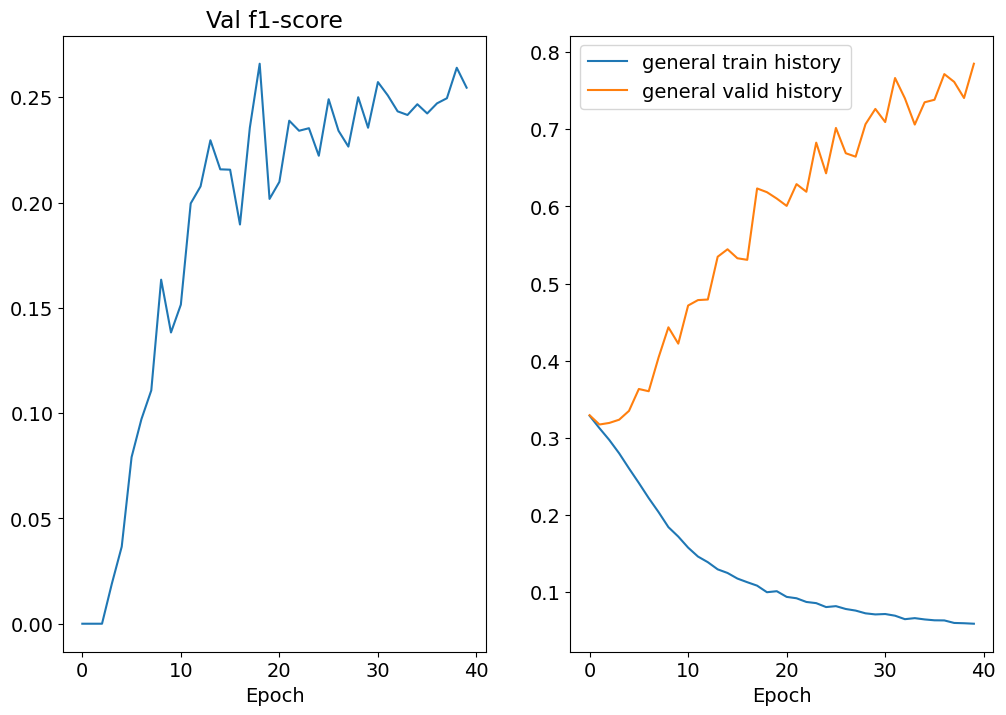

Epoch: 40 | Time: 0m 50s
	Train Loss: 0.059
	 Val. Loss: 0.785 |  Val. F1: 0.255


In [28]:
train_evaluate(bert_simple_clf, train_loader, dev_loader, optimizer,
               criterion, N_EPOCHS, "text_only_baseline", device)

In [29]:
bert_simple_clf.load_state_dict(torch.load('best-val-text_only_baseline.pt'))

<All keys matched successfully>

### Evaluation on dev set

In [30]:
true_labels, pred_labels = predict(bert_simple_clf, dev_loader, device)
print(f"{precision_score(true_labels, pred_labels)},{recall_score(true_labels, pred_labels)},{f1_score(true_labels, pred_labels)}")

0.31555555555555553,0.2297734627831715,0.26591760299625467


### Evaluation on test set

In [31]:
true_labels, pred_labels = predict(bert_simple_clf, test_loader, device)
print(f"{precision_score(true_labels, pred_labels)},{recall_score(true_labels, pred_labels)},{f1_score(true_labels, pred_labels)}")

0.3002070393374741,0.19129287598944592,0.233682514101531


In [32]:
test_df["true_y"] = true_labels
test_df["prediction"] = pred_labels

/tmp/ipykernel_24/196693343.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["true_y"] = true_labels
/tmp/ipykernel_24/196693343.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["prediction"] = pred_labels


In [33]:
test_pred_path = "test_pred_mpnet_nograph_baseline.tsv"
test_df.to_csv(test_pred_path, sep='\t', index=False)
# test_df[["id", "prediction"]].to_csv(test_pred_path, sep='\t', index=False)

In [34]:
# del bert_simple_clf
# del bert_model
# del optimizer
# del criterion

## Linearized graph baseline

In [35]:
SEP_TOKEN = tokenizer.sep_token

In [36]:
# {'directed': True, 'multigraph': False, 'graph': {},
# 'nodes': [{'type': 'QUESTIONS_ENTITY', 'name_': 'Q49', 'id': 0, 'label': 'North America'},
# {'type': 'ANSWER_CANDIDATE_ENTITY', 'name_': 'Q194057', 'id': 1, 'label': 'Mount Rainier'}],
# 'links': [{'name_': 'P30', 'source': 1, 'target': 0, 'label': 'continent'}]}
def linearize_graph(graph_dict):
    nodes = sorted((node_dict for node_dict in graph_dict["nodes"]), key=lambda d:d["id"])
    for n_id, node_dict in enumerate(nodes):
        assert n_id == node_dict["id"]
    src_node_id2links = {}
    # print("graph_dict", graph_dict)
    # print("links", graph_dict["links"])
    for link_dict in graph_dict["links"]:
        link_src =  link_dict["source"]
        if src_node_id2links.get(link_src) is None:
            src_node_id2links[link_src] = []
        src_node_id2links[link_src].append(link_dict)
    graph_s = ""
    # print("src_node_id2links", src_node_id2links)
    for n_id, node_dict in enumerate(nodes):
        links = src_node_id2links.get(n_id, list())
        start_label = node_dict["label"]
        if node_dict["type"] == "ANSWER_CANDIDATE_ENTITY":
            start_label = f"{SEP_TOKEN} {start_label} {SEP_TOKEN}"
        for link_dict in links:
            target_label = nodes[link_dict["target"]]["label"]
            if nodes[link_dict["target"]]["type"] == "ANSWER_CANDIDATE_ENTITY":
                target_label = f"{SEP_TOKEN} {target_label} {SEP_TOKEN}"
            link_s = f" {start_label}, {link_dict['label']}, {target_label} "
            graph_s += link_s
        # graph_s += node_dict["label"]
        # print("n_id, node_dict", n_id, node_dict)
        # if n_id != len(nodes) - 1:


        #     link_label = link["label"]
        #     graph_s += link_label
    # print('--')
    return graph_s

In [37]:
train_df["linearized_graph"] = train_df["graph"].apply(linearize_graph)
dev_df["linearized_graph"] = dev_df["graph"].apply(linearize_graph)
test_df["linearized_graph"] = test_df["graph"].apply(linearize_graph)

/tmp/ipykernel_24/2265556522.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["linearized_graph"] = train_df["graph"].apply(linearize_graph)
/tmp/ipykernel_24/2265556522.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dev_df["linearized_graph"] = dev_df["graph"].apply(linearize_graph)
/tmp/ipykernel_24/2265556522.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

In [38]:
pd.set_option('display.max_colwidth', None)

In [39]:
train_df["linearized_graph"].head()

0                                                                                                                                                                                                                                                                                                                 Iran, country, Iran  Iran, replaces, Pahlavi dynasty  Pahlavi dynasty, replaced by, Iran  [SEP] Ruhollah Khomeini's return to Iran [SEP], country, Pahlavi dynasty 
1     Iran, described by source, Jewish Encyclopedia of Brockhaus and Efron  Iran, country, Iran  letter, described by source, Jewish Encyclopedia of Brockhaus and Efron  letter, subclass of, written work  The Book of Healing, country of origin, Iran  The Book of Healing, instance of, written work  [SEP] Ruhollah Khomeini's letter to Mikhail Gorbachev [SEP], instance of, written work  [SEP] Ruhollah Khomeini's letter to Mikhail Gorbachev [SEP], instance of, letter 
2                                                           

In [40]:
dev_df["linearized_graph"].head()

259                                                                                                                                                                                                                                                                             United States, country, United States  [SEP] Truman Capote [SEP], country of citizenship, United States  To Kill a Mockingbird, country of origin, United States 
260                                                                                                                                                                                                                                United States, country, United States  National Gallery of Art, country, United States  To Kill a Mockingbird, country of origin, United States  [SEP] Truman Capote [SEP], location, National Gallery of Art 
261                                                                                                                                 

In [41]:
test_df["linearized_graph"].head()

11                                                                                                        [SEP] Yogi Berra [SEP], league, Major League Baseball 
12     United States, country, United States  Major League Baseball, country, United States  [SEP] Tony Gwynn, Jr. [SEP], country of citizenship, United States 
13                                                                                                    [SEP] Roy Campanella [SEP], league, Major League Baseball 
14                                                                                                     [SEP] Roger Clemens [SEP], league, Major League Baseball 
15                                                                                                     [SEP] Mickey Mantle [SEP], league, Major League Baseball 
Name: linearized_graph, dtype: object

In [42]:
model_name="sentence-transformers/all-MiniLM-L6-v2"

tokenizer = AutoTokenizer.from_pretrained(model_name)
bert_model = AutoModel.from_pretrained(model_name)

freeze_embeddings = True
if freeze_embeddings:
    for param in bert_model.embeddings.parameters():
        param.requires_grad = False

# freeze_layer_count = 5
# if freeze_layer_count > 0:
#     for layer in bert_model.encoder.layer[:freeze_layer_count]:
#         for param in layer.parameters():
#             param.requires_grad = False

print("# Trainable params: ", sum(p.numel() for p in bert_model.parameters() if p.requires_grad))

# Trainable params:  10794624


In [43]:
max_length = 128
train_dataset = QuestionAnswerDataset(train_df, tokenizer=tokenizer, max_length=max_length, context_key="linearized_graph",
                                      tokenizer_truncation="only_second")
dev_dataset = QuestionAnswerDataset(dev_df, tokenizer=tokenizer, max_length=max_length, context_key="linearized_graph",
                                    tokenizer_truncation="only_second")
test_dataset = QuestionAnswerDataset(test_df, tokenizer=tokenizer, max_length=max_length, context_key="linearized_graph",
                                     tokenizer_truncation="only_second")

In [44]:
batch_size = 64
num_workers = 0

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True, drop_last=True,
)
dev_loader = torch.utils.data.DataLoader(
    dev_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False, drop_last=False,
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False, drop_last=False,
)

In [45]:
N_EPOCHS = 40
DROPOUT = 0.2

In [46]:
bert_linearized_graph_clf = BertSimpleClassifier(bert_model, dropout=DROPOUT).to(device)
optimizer = optim.Adam(bert_linearized_graph_clf.parameters(), lr=3e-5)
criterion = nn.BCEWithLogitsLoss()

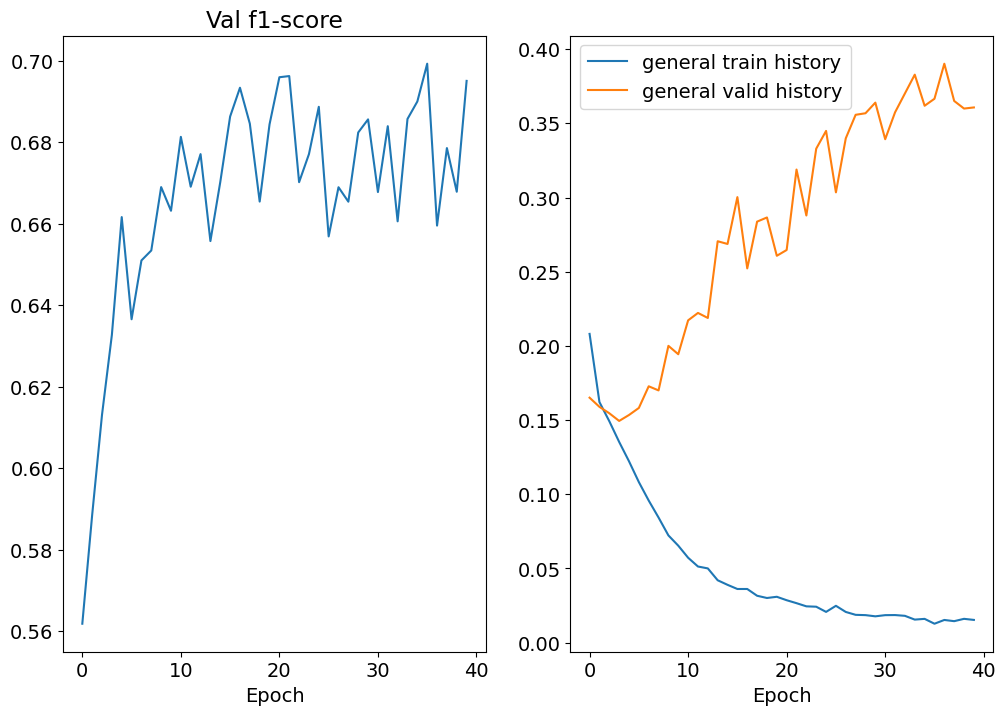

Epoch: 40 | Time: 0m 50s
	Train Loss: 0.015
	 Val. Loss: 0.361 |  Val. F1: 0.695


In [47]:
train_evaluate(bert_linearized_graph_clf, train_loader, dev_loader, optimizer,
               criterion, N_EPOCHS, "bert_linearized_graph_clf", device)

In [48]:
bert_linearized_graph_clf.load_state_dict(torch.load('best-val-bert_linearized_graph_clf.pt'))

<All keys matched successfully>

### Evaluation on dev set

In [49]:
true_labels, pred_labels = predict(bert_linearized_graph_clf, dev_loader, device)
print(f"{precision_score(true_labels, pred_labels)},{recall_score(true_labels, pred_labels)},{f1_score(true_labels, pred_labels)}")

0.7942386831275721,0.6245954692556634,0.6992753623188406


### Evaluation on test set

In [50]:
true_labels, pred_labels = predict(bert_linearized_graph_clf, test_loader, device)
print(f"{precision_score(true_labels, pred_labels)},{recall_score(true_labels, pred_labels)},{f1_score(true_labels, pred_labels)}")

0.7183098591549296,0.5382585751978892,0.6153846153846154


In [51]:
assert len(true_labels) == len(pred_labels)

In [52]:
test_df["true_y"] = true_labels
test_df["prediction"] = pred_labels


/tmp/ipykernel_24/520965589.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["true_y"] = true_labels
/tmp/ipykernel_24/520965589.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["prediction"] = pred_labels


In [53]:
test_df.head()

,sample_id,question,questionEntity,answerEntity,groundTruthAnswerEntity,answerEntityId,questionEntityId,groundTruthAnswerEntityId,correct,graph,label,true_y,prediction,linearized_graph
11,11,Whose is the oldest MLB player to hit a home run?,Major League Baseball,Yogi Berra,Julio Franco,Q367566,Q1163715,Q487717,False,"{'nodes': [{'type': 'QUESTIONS_ENTITY', 'name_': 'Q1163715', 'id': 0, 'label': 'Major League Baseball'}, {'type': 'ANSWER_CANDIDATE_ENTITY', 'name_': 'Q367566', 'id': 1, 'label': 'Yogi Berra'}], 'links': [{'name_': 'P118', 'source': 1, 'target': 0, 'label': 'league'}]}",0.0,0.0,0,"[SEP] Yogi Berra [SEP], league, Major League Baseball"
12,12,Whose is the oldest MLB player to hit a home run?,Major League Baseball,"Tony Gwynn, Jr.",Julio Franco,Q3531782,Q1163715,Q487717,False,"{'nodes': [{'type': 'INTERNAL', 'name_': 'Q30', 'id': 0, 'label': 'United States'}, {'type': 'QUESTIONS_ENTITY', 'name_': 'Q1163715', 'id': 1, 'label': 'Major League Baseball'}, {'type': 'ANSWER_CANDIDATE_ENTITY', 'name_': 'Q3531782', 'id': 2, 'label': 'Tony Gwynn, Jr.'}], 'links': [{'name_': 'P17', 'source': 0, 'target': 0, 'label': 'country'}, {'name_': 'P17', 'source': 1, 'target': 0, 'label': 'country'}, {'name_': 'P27', 'source': 2, 'target': 0, 'label': 'country of citizenship'}]}",0.0,0.0,0,"United States, country, United States Major League Baseball, country, United States [SEP] Tony Gwynn, Jr. [SEP], country of citizenship, United States"
13,13,Whose is the oldest MLB player to hit a home run?,Major League Baseball,Roy Campanella,Julio Franco,Q735795,Q1163715,Q487717,False,"{'nodes': [{'type': 'QUESTIONS_ENTITY', 'name_': 'Q1163715', 'id': 0, 'label': 'Major League Baseball'}, {'type': 'ANSWER_CANDIDATE_ENTITY', 'name_': 'Q735795', 'id': 1, 'label': 'Roy Campanella'}], 'links': [{'name_': 'P118', 'source': 1, 'target': 0, 'label': 'league'}]}",0.0,0.0,1,"[SEP] Roy Campanella [SEP], league, Major League Baseball"
14,14,Whose is the oldest MLB player to hit a home run?,Major League Baseball,Roger Clemens,Julio Franco,Q473208,Q1163715,Q487717,False,"{'nodes': [{'type': 'QUESTIONS_ENTITY', 'name_': 'Q1163715', 'id': 0, 'label': 'Major League Baseball'}, {'type': 'ANSWER_CANDIDATE_ENTITY', 'name_': 'Q473208', 'id': 1, 'label': 'Roger Clemens'}], 'links': [{'name_': 'P118', 'source': 1, 'target': 0, 'label': 'league'}]}",0.0,0.0,0,"[SEP] Roger Clemens [SEP], league, Major League Baseball"
15,15,Whose is the oldest MLB player to hit a home run?,Major League Baseball,Mickey Mantle,Julio Franco,Q345004,Q1163715,Q487717,False,"{'nodes': [{'type': 'QUESTIONS_ENTITY', 'name_': 'Q1163715', 'id': 0, 'label': 'Major League Baseball'}, {'type': 'ANSWER_CANDIDATE_ENTITY', 'name_': 'Q345004', 'id': 1, 'label': 'Mickey Mantle'}], 'links': [{'name_': 'P118', 'source': 1, 'target': 0, 'label': 'league'}]}",0.0,0.0,0,"[SEP] Mickey Mantle [SEP], league, Major League Baseball"


In [54]:
test_df[["question", "answerEntity", "groundTruthAnswerEntity", "true_y", "prediction", "label"]].head(50)

,question,answerEntity,groundTruthAnswerEntity,true_y,prediction,label
11,Whose is the oldest MLB player to hit a home run?,Yogi Berra,Julio Franco,0.0,0,0.0
12,Whose is the oldest MLB player to hit a home run?,"Tony Gwynn, Jr.",Julio Franco,0.0,0,0.0
13,Whose is the oldest MLB player to hit a home run?,Roy Campanella,Julio Franco,0.0,1,0.0
14,Whose is the oldest MLB player to hit a home run?,Roger Clemens,Julio Franco,0.0,0,0.0
15,Whose is the oldest MLB player to hit a home run?,Mickey Mantle,Julio Franco,0.0,0,0.0
16,Whose is the oldest MLB player to hit a home run?,Lou Gehrig,Julio Franco,0.0,0,0.0
17,Whose is the oldest MLB player to hit a home run?,Julio Franco,Julio Franco,1.0,0,1.0
18,Whose is the oldest MLB player to hit a home run?,José Bautista,Julio Franco,0.0,0,0.0
19,Whose is the oldest MLB player to hit a home run?,Hank Greenberg,Julio Franco,0.0,0,0.0
20,Whose is the oldest MLB player to hit a home run?,Hank Aaron,Julio Franco,0.0,0,0.0


In [55]:
test_pred_path = "test_pred_linearized_graph_baseline.tsv"
test_df[["sample_id", "prediction"]].to_csv(test_pred_path, sep='\t', index=False)